# **Car price prediction**

In [5]:
# STEP 0: import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#apis
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
#modules
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

#normal lib
from statistics import mean
import joblib
import seaborn as sns

# **STEP 1. LOOK AT THE BIG PICTURE**
# tell briefly about car prices and what features have been used

In [6]:
#STEP 2: GET THE DATA 
raw_data = pd.read_csv(r'C:\Users\lnkhu\OneDrive\Desktop\rmit\Modelling\asm3\car_price_prediction.csv')

In [7]:
# STEP 3: EDA 
# 3.1. briefly analyse the dataset with info, head and describe()
print("Dataset info:")
print(raw_data.info())

print("Data briefing: ")
print(raw_data.head())

print("Data describe: ")
raw_data.describe()

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 no

,ID,Price,Prod. year,Cylinders,Airbags
count,1.923700e+04,1.923700e+04,19237.000000,19237.000000,19237.000000
mean,4.557654e+07,1.855593e+04,2010.912824,4.582991,6.582627
std,9.365914e+05,1.905813e+05,5.668673,1.199933,4.320168
min,2.074688e+07,1.000000e+00,1939.000000,1.000000,0.000000
25%,4.569837e+07,5.331000e+03,2009.000000,4.000000,4.000000
50%,4.577231e+07,1.317200e+04,2012.000000,4.000000,6.000000
75%,4.580204e+07,2.207500e+04,2015.000000,4.000000,12.000000
max,4.581665e+07,2.630750e+07,2020.000000,16.000000,16.000000


In [8]:
# 3.1.1. Missing values:
print("Missing values: ")
print(raw_data.isna().sum())

Missing values: 
ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64


In [9]:
#reformat data
#cleaning the mileague
raw_data['Mileage'] = raw_data['Mileage'].str.extract('(\d+)').astype(int)

# extracting the enginer volume
raw_data['Turbo'] = raw_data['Engine volume'].apply(lambda x: 1 if 'Turbo' in x else 0)
raw_data['Turbo'] = raw_data['Turbo'].map({1: 'Yes', 0: 'No'})

raw_data['Engine volume'] = raw_data['Engine volume'].str.extract(r'(\d+\.\d+|\d+)').astype(float)

# set empty levy = -1
raw_data['Levy'] = raw_data['Levy'].replace('-', 0)
raw_data['Levy'] = pd.to_numeric(raw_data['Levy'])
# drop the unused data
# raw_data = raw_data[raw_data['Levy'] > 0]

#production year to be a string
raw_data['Doors'] = raw_data['Doors'].str.replace('May', '5')
raw_data['Doors'] = raw_data['Doors'].str.replace('Mar', '3')
raw_data['Doors'] = raw_data['Doors'].str.replace('04', '4')
raw_data['Doors'] = raw_data['Doors'].str.replace('02', '2')



#drop the ID column
raw_data = raw_data.drop(columns = "ID")
raw_data.describe()

,Price,Levy,Prod. year,Engine volume,Mileage,Cylinders,Airbags
count,1.923700e+04,19237.000000,19237.000000,19237.000000,1.923700e+04,19237.000000,19237.000000
mean,1.855593e+04,632.528669,2010.912824,2.307990,1.532236e+06,4.582991,6.582627
std,1.905813e+05,567.721688,5.668673,0.877805,4.840387e+07,1.199933,4.320168
min,1.000000e+00,0.000000,1939.000000,0.000000,0.000000e+00,1.000000,0.000000
25%,5.331000e+03,0.000000,2009.000000,1.800000,7.013900e+04,4.000000,4.000000
50%,1.317200e+04,642.000000,2012.000000,2.000000,1.260000e+05,4.000000,6.000000
75%,2.207500e+04,917.000000,2015.000000,2.500000,1.888880e+05,4.000000,12.000000
max,2.630750e+07,11714.000000,2020.000000,20.000000,2.147484e+09,16.000000,16.000000


In [10]:
cols=raw_data.columns
num_cols = raw_data._get_numeric_data()
num_cols= list(num_cols.columns)
cat_cols = list(set(cols) - set(num_cols))
cat_cols.sort()

#remove the color

print(f"Numerical features: {num_cols}")
print(f"Categorical features: {cat_cols}")


Numerical features: ['Price', 'Levy', 'Prod. year', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags']
Categorical features: ['Category', 'Color', 'Doors', 'Drive wheels', 'Fuel type', 'Gear box type', 'Leather interior', 'Manufacturer', 'Model', 'Turbo', 'Wheel']


In [11]:
raw_data.head()

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo
0,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,4-5,Left wheel,Silver,12,No
1,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000,6.0,Tiptronic,4x4,4-5,Left wheel,Black,8,No
2,8467,0,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,4-5,Right-hand drive,Black,2,No
3,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,4-5,Left wheel,White,0,No
4,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,4-5,Left wheel,Silver,4,No


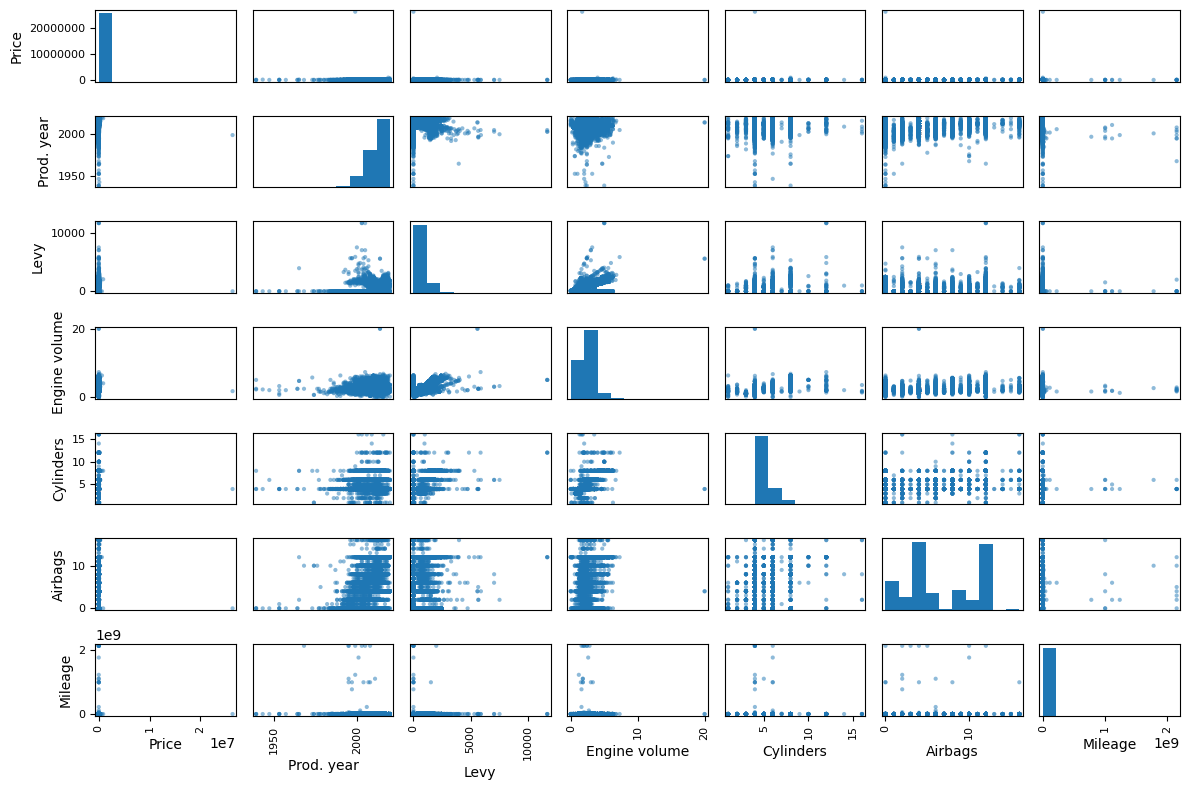

In [12]:
# 3.x. scatter matrix of numerical data
from pandas.plotting import scatter_matrix
def scatter(raw_data):
	attributes = ['Price', 'Prod. year', 'Levy', 'Engine volume', 'Cylinders', 'Airbags', 'Mileage'	]
	scatter_matrix(raw_data[attributes], figsize=(12, 8))
	plt.tight_layout()
	plt.show()
scatter(raw_data)

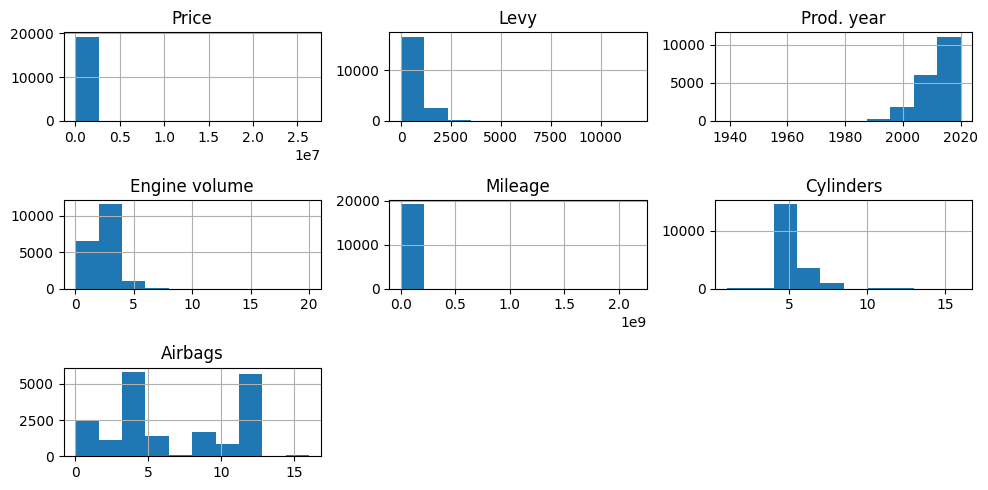

In [13]:
raw_data.hist(figsize=(10,5)) #bins: no. of intervals
plt.tight_layout()
# plt.rcParams['xtick.labelsize'] = 10
# plt.rcParams['ytick.labelsize'] = 10


In [14]:
print("Before refining the dataset")
corr_matrix = raw_data.corr(numeric_only=True)
print(corr_matrix)

Before refining the dataset
                  Price      Levy  Prod. year  Engine volume   Mileage  \
Price          1.000000 -0.003701    0.012982       0.008753 -0.001758   
Levy          -0.003701  1.000000    0.364712       0.377438 -0.021034   
Prod. year     0.012982  0.364712    1.000000      -0.030906 -0.063501   
Engine volume  0.008753  0.377438   -0.030906       1.000000 -0.006289   
Mileage       -0.001758 -0.021034   -0.063501      -0.006289  1.000000   
Cylinders      0.007518  0.250950   -0.096797       0.778524 -0.001768   
Airbags       -0.012824  0.128032    0.236969       0.224441 -0.009201   

               Cylinders   Airbags  
Price           0.007518 -0.012824  
Levy            0.250950  0.128032  
Prod. year     -0.096797  0.236969  
Engine volume   0.778524  0.224441  
Mileage        -0.001768 -0.009201  
Cylinders       1.000000  0.176868  
Airbags         0.176868  1.000000  


                  Price      Levy  Prod. year  Engine volume   Mileage  \
Price          1.000000 -0.003701    0.012982       0.008753 -0.001758   
Levy          -0.003701  1.000000    0.364712       0.377438 -0.021034   
Prod. year     0.012982  0.364712    1.000000      -0.030906 -0.063501   
Engine volume  0.008753  0.377438   -0.030906       1.000000 -0.006289   
Mileage       -0.001758 -0.021034   -0.063501      -0.006289  1.000000   
Cylinders      0.007518  0.250950   -0.096797       0.778524 -0.001768   
Airbags       -0.012824  0.128032    0.236969       0.224441 -0.009201   

               Cylinders   Airbags  
Price           0.007518 -0.012824  
Levy            0.250950  0.128032  
Prod. year     -0.096797  0.236969  
Engine volume   0.778524  0.224441  
Mileage        -0.001768 -0.009201  
Cylinders       1.000000  0.176868  
Airbags         0.176868  1.000000  

 Price            1.000000
Prod. year       0.012982
Engine volume    0.008753
Cylinders        0.007518
Milea

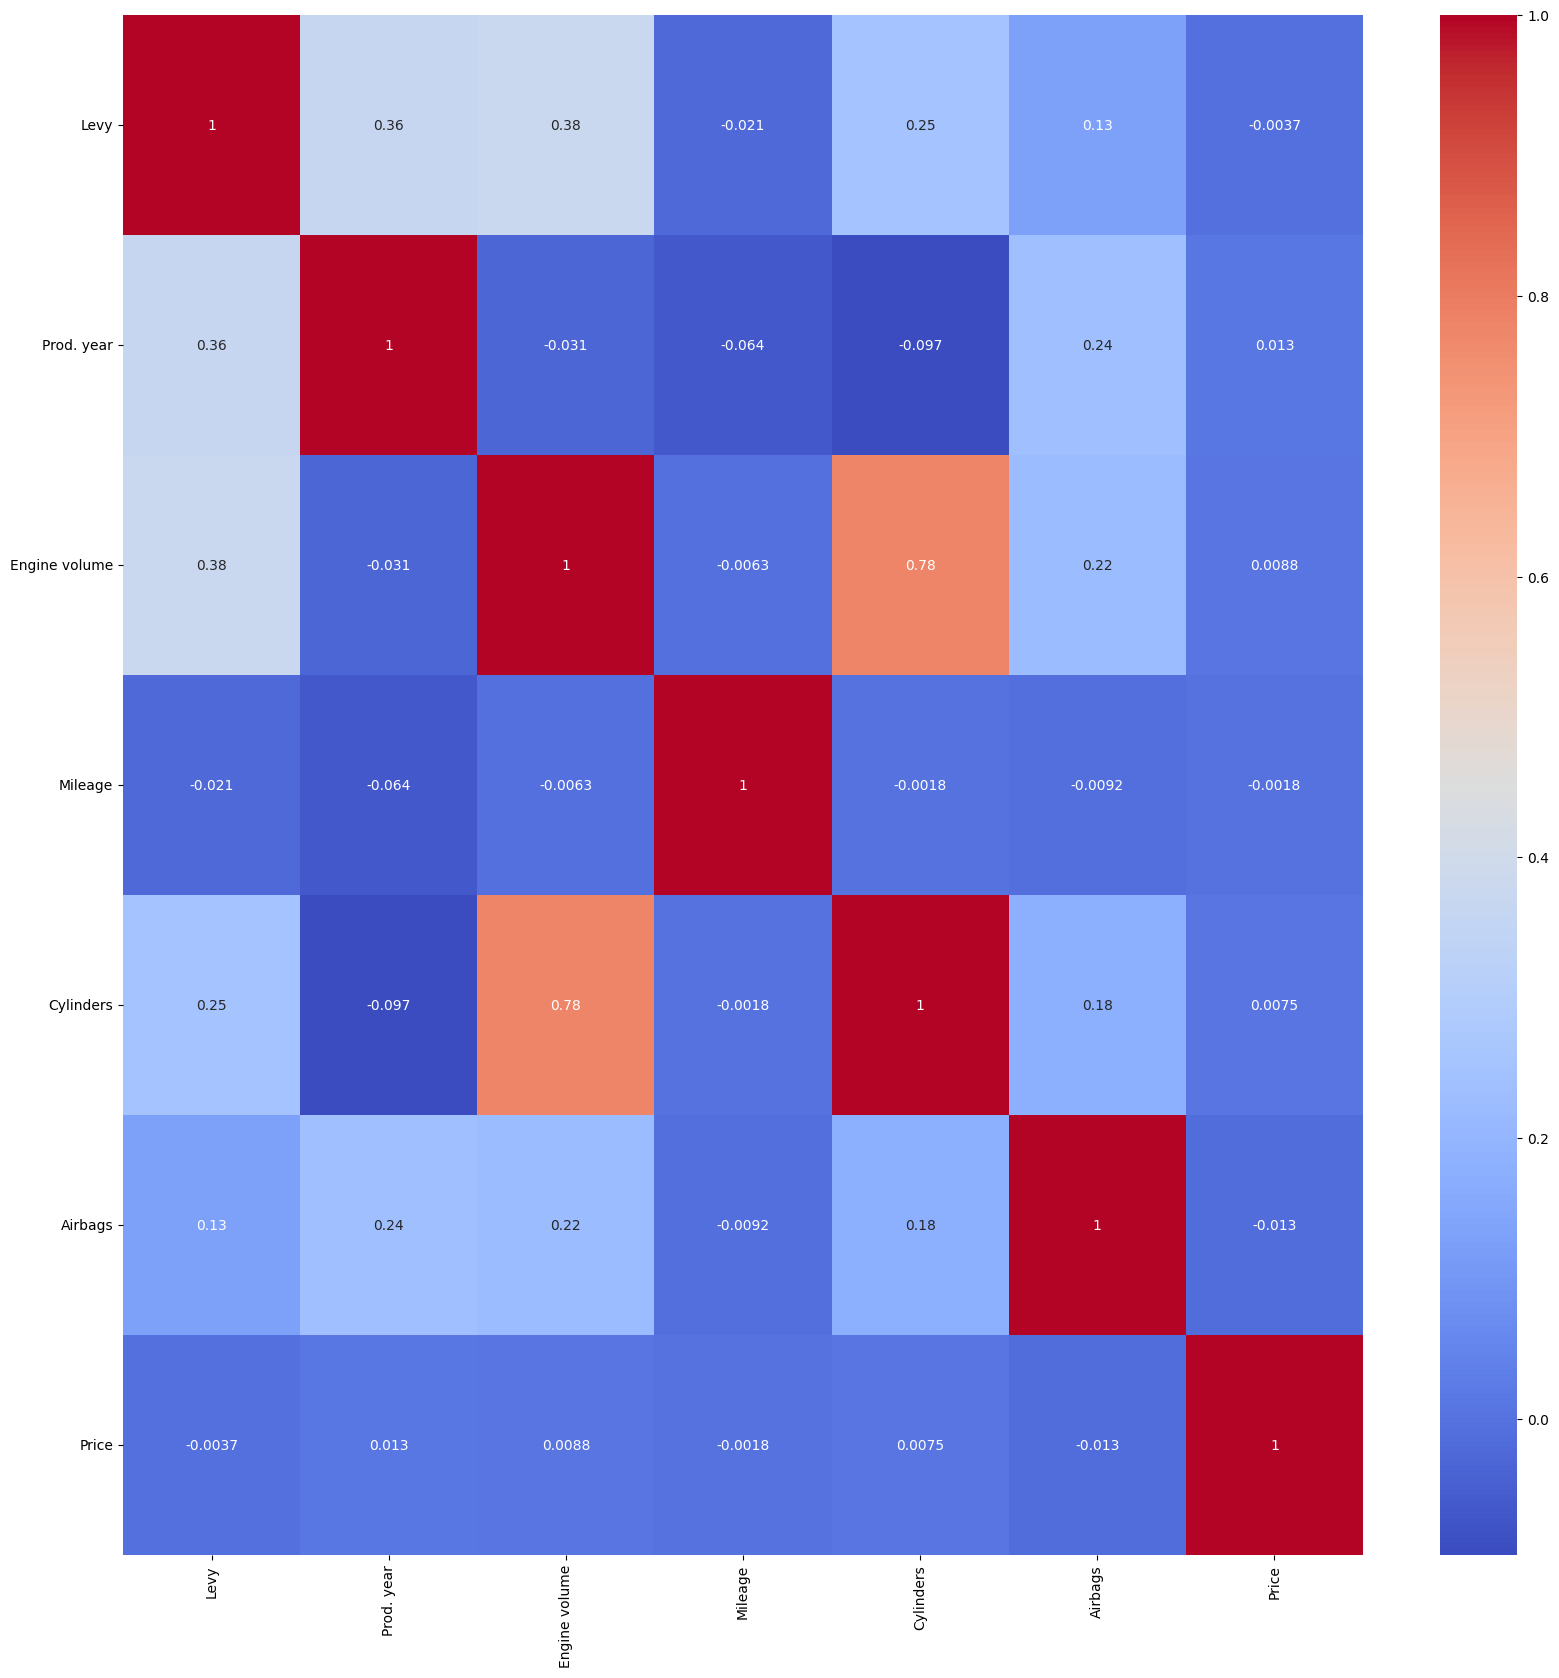

Cylinders
4.0     14367
6.0      3462
8.0       991
5.0       169
3.0       107
2.0        42
1.0        38
12.0       38
10.0       12
16.0        5
7.0         4
9.0         1
14.0        1
Name: count, dtype: int64


In [15]:
# 3.4 Correlation matrix
corr_matrix = raw_data.corr(numeric_only=True)
print(corr_matrix) # print correlation matrix
print('\n',corr_matrix["Price"].sort_values(ascending=False)) # print correlation b/w a feature and other features


columns = list(corr_matrix.columns)
columns.remove('Price')
columns.append('Price')
corr_matrix = corr_matrix. loc[columns, columns]

# Create a heatmap from the correlation matrix
plt. figure(figsize=(20, 20))
sns. heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.xticks(rotation=90, fontsize=10)
# Rotate y-axis labels
plt.yticks(rotation=0, fontsize=10)
plt.show()
print(raw_data['Cylinders'].value_counts()) 


In [16]:
# Pair plot
# sns.pairplot(raw_data)
# plt.show()

In [17]:
# # 3.x Try combining features
# corr_matrix = raw_data.corr(numeric_only=True)
# print(corr_matrix["PRICE IN MILLION VND"].sort_values(ascending=False)) # print correlation b/w a feature and other features
# raw_data.drop(columns = ["AREA PER ROOM", "TOTAL NUMBER OF ROOMS"], inplace=True) # remove experiment columns

# EDA on categorical features

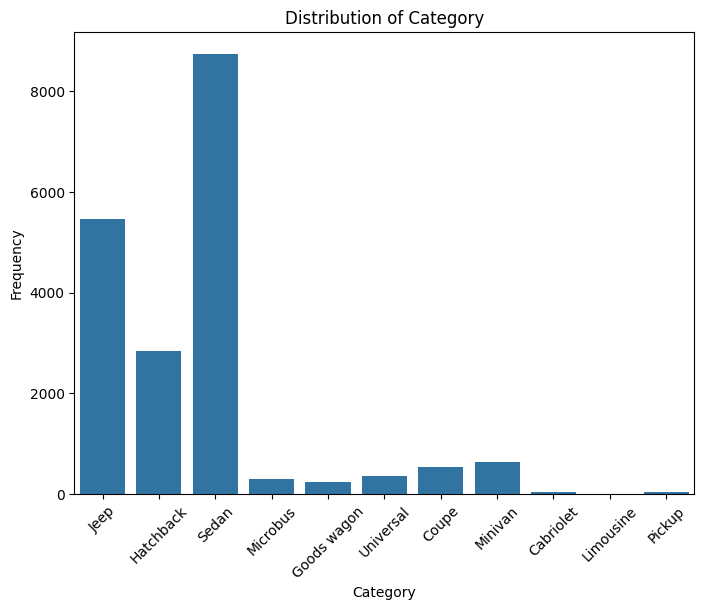

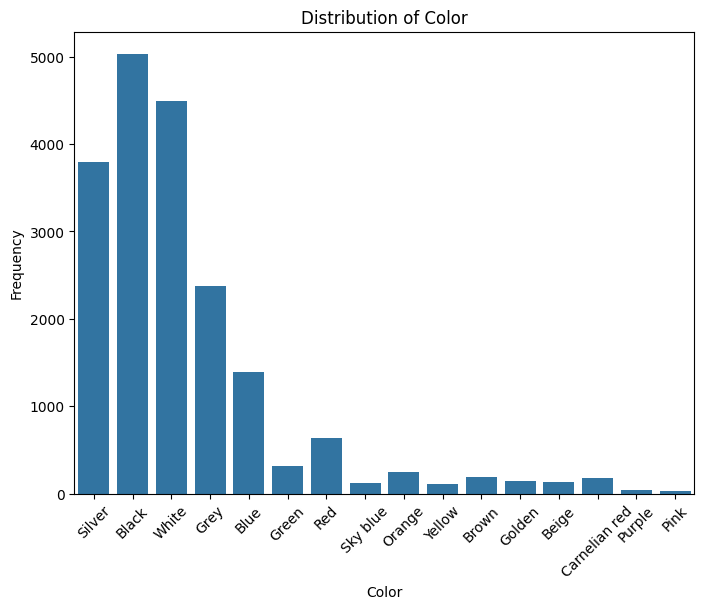

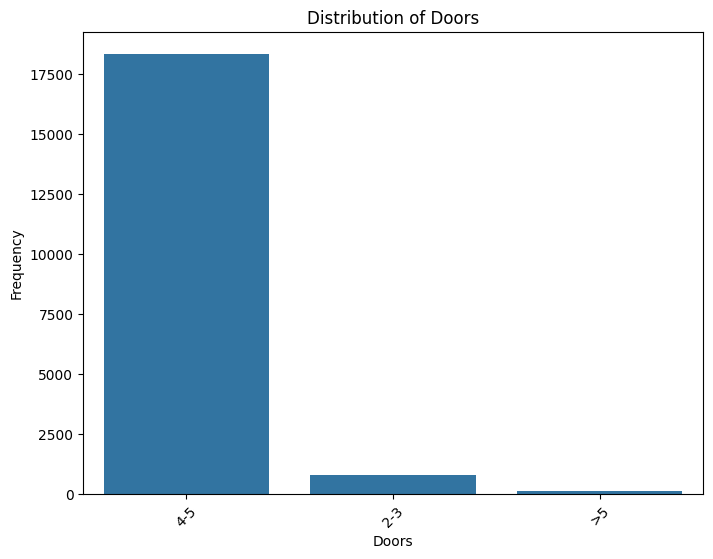

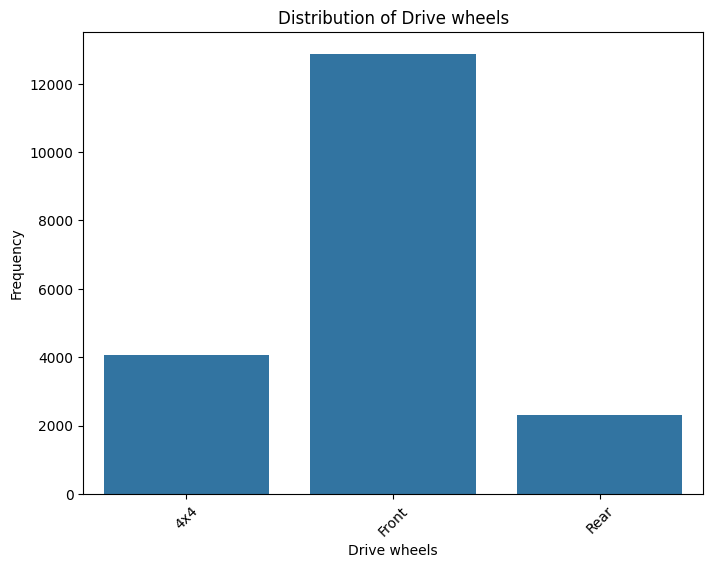

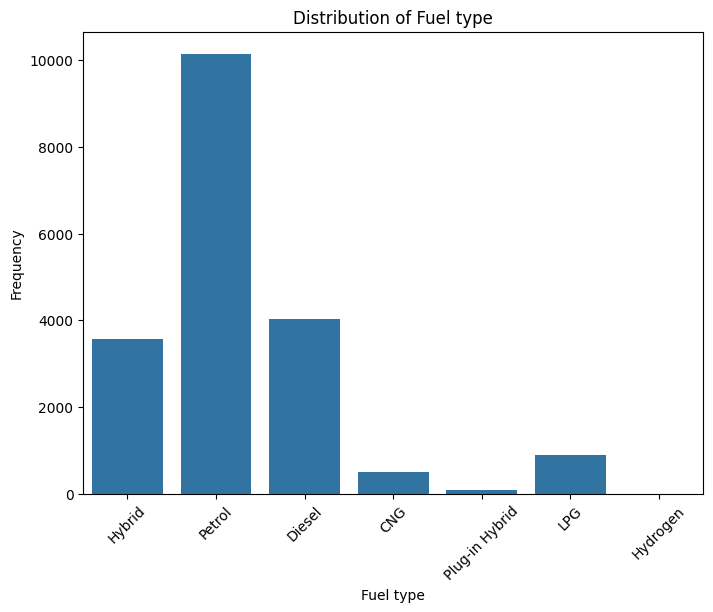

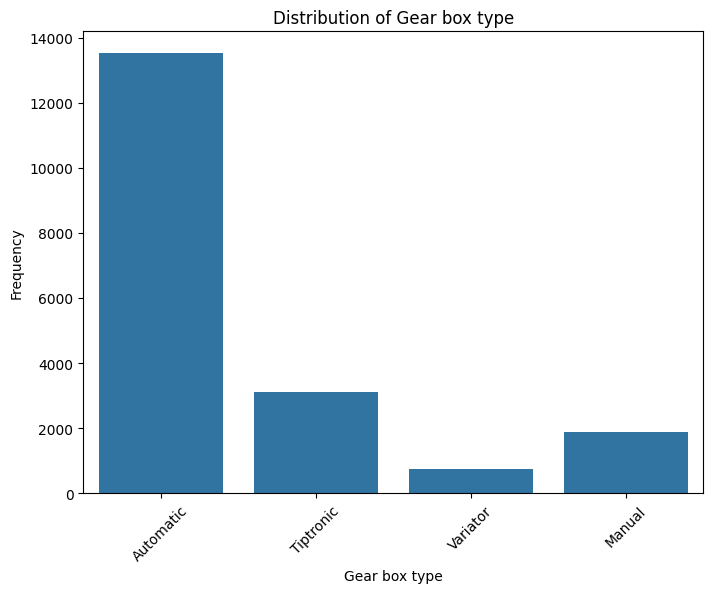

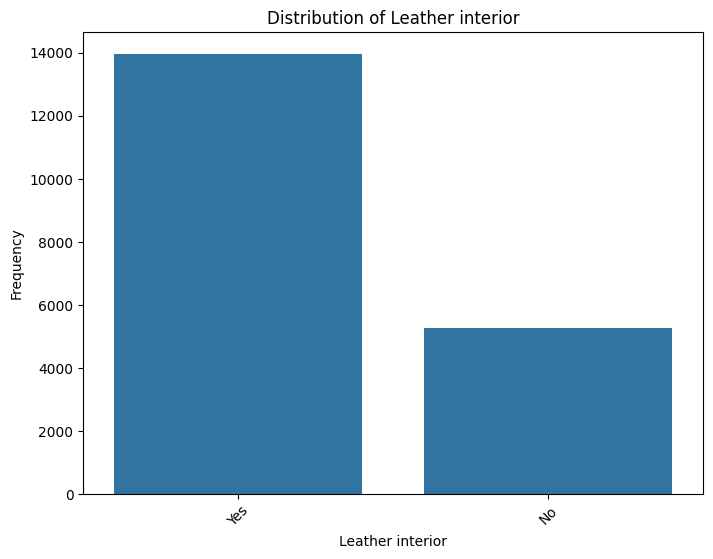

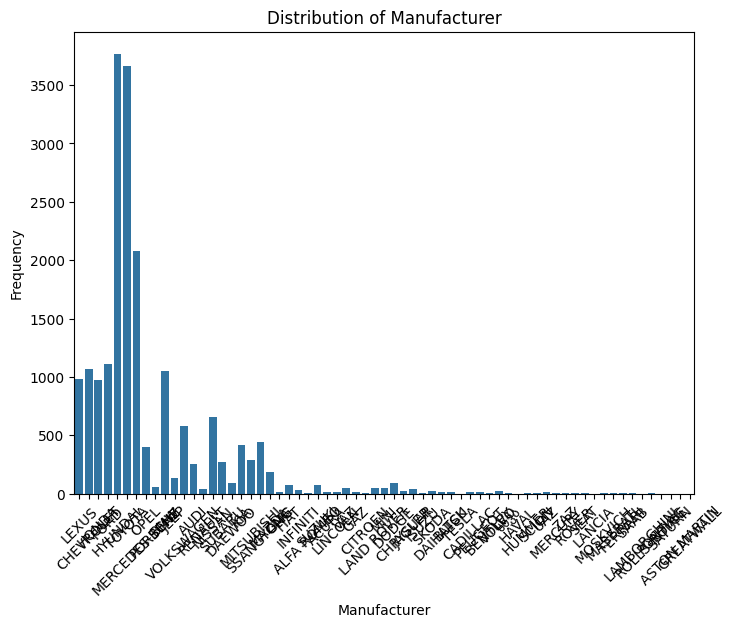

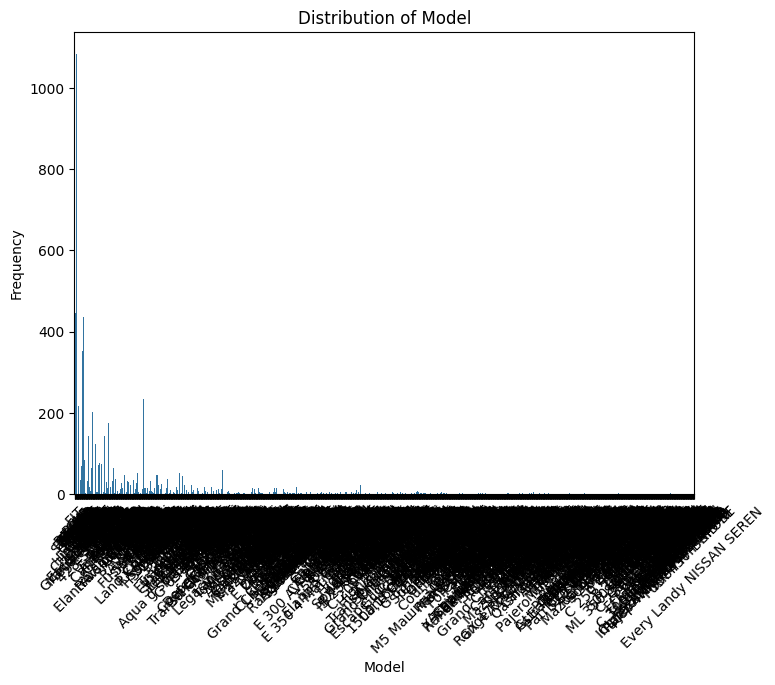

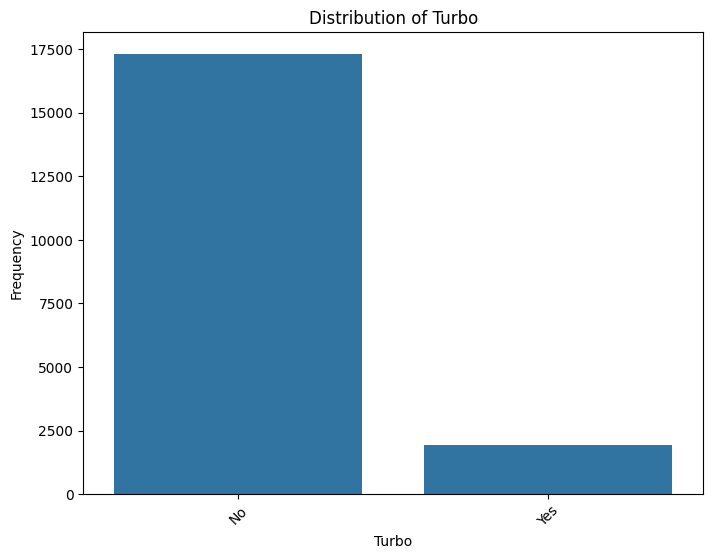

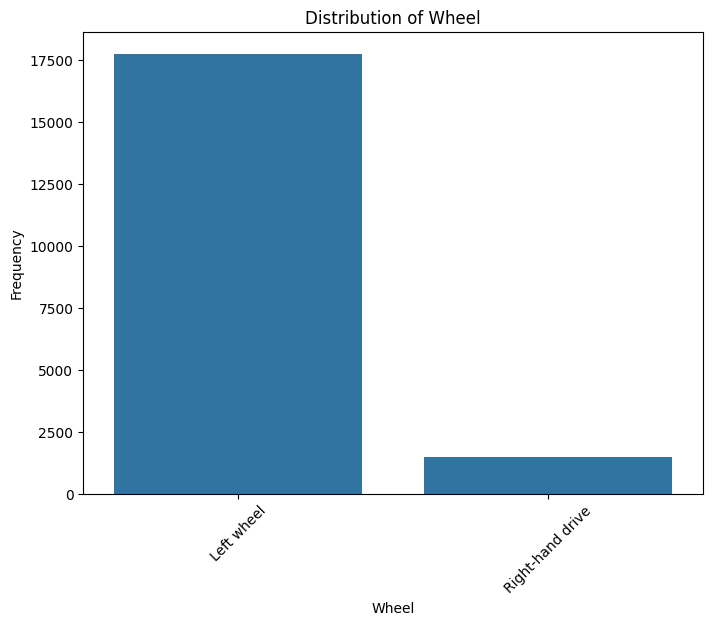

In [18]:
for feature in cat_cols:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=feature, data=raw_data)
    plt.xlabel(feature.capitalize())
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {feature.capitalize()}')
    plt.xticks(rotation=45)
    plt.show()
# print(cat_cols)

# Feature engineering

# STEP 4. PREPARE THE DATA 


In [19]:
# 4.1 Remove unused features
#print(raw_data)

In [20]:
# Check normality summary
def normality_sum(df):
    num_col = df.select_dtypes(include=[np.number]).columns

    result = []
    for col in num_col:
        skewness = df[col].skew()
        kurtosis = df[col].kurtosis()
        result.append({
            'Variable' : col,
            'Skewness' : skewness,
            'Kurtosis' : kurtosis,
            'Mean' : df[col].mean(),
            'Median' : df[col].median(),
            'Std Dev' : df[col].std(),
            'Potential Normal' : abs(skewness) <= 1 and abs(kurtosis) <= 3
        })

    return pd.DataFrame(result)

normality_df = normality_sum(raw_data.drop(['Price'], axis =1))
print("Summary")
print(normality_df)


Summary
        Variable   Skewness     Kurtosis          Mean    Median  \
0           Levy   2.376222    29.213355  6.325287e+02     642.0   
1     Prod. year  -2.082261    11.329766  2.010913e+03    2012.0   
2  Engine volume   2.186242    19.222583  2.307990e+00       2.0   
3        Mileage  38.896821  1598.756423  1.532236e+06  126000.0   
4      Cylinders   2.091083     6.486085  4.582991e+00       4.0   
5        Airbags   0.082012    -1.334021  6.582627e+00       6.0   

        Std Dev  Potential Normal  
0  5.677217e+02             False  
1  5.668673e+00             False  
2  8.778045e-01             False  
3  4.840387e+07             False  
4  1.199933e+00             False  
5  4.320168e+00              True  


In [21]:
def remove_outliers_iqr(data, factor=1.5):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    iqr = Q3 - Q1
    lower_bound = Q1 - factor * iqr
    upper_bound = Q3 + factor * iqr
    return lower_bound, upper_bound

# Assuming raw_data is a DataFrame and num_cols is a list of numerical columns
data_no_outliers = raw_data.copy()

# Remove rows where 'price' is less than 500
data_no_outliers = data_no_outliers[data_no_outliers['Price'] >= 500]

data_no_outliers["Price_after_tax"] = data_no_outliers["Price"] + data_no_outliers["Levy"] 
attributes = ['Prod. year', 'Engine volume', 'Mileage', 'Airbags', 'Price_after_tax']


for attribute in attributes:
    low, high = remove_outliers_iqr(data_no_outliers[attribute], factor=1.5)
    print(attribute, low, high)
    # Filter out rows where the attribute is an outlier
    outliers = (data_no_outliers[attribute] < low) | (data_no_outliers[attribute] > high)
    
    # Drop the outlier rows
    data_no_outliers = data_no_outliers[~outliers]

data_no_outliers.describe()

Prod. year 2000.0 2024.0
Engine volume 0.7500000000000002 3.55
Mileage -93861.5 343102.5
Airbags -8.0 24.0
Price_after_tax -14311.75 47726.25


,Price,Levy,Prod. year,Engine volume,Mileage,Cylinders,Airbags,Price_after_tax
count,14001.000000,14001.000000,14001.000000,14001.000000,14001.000000,14001.000000,14001.000000,14001.000000
mean,16080.551103,603.989572,2011.543604,2.122506,127487.205200,4.349689,6.682094,16684.540676
std,10871.124671,473.413169,4.217918,0.591450,74542.241984,0.866517,4.112299,10870.141856
min,500.000000,0.000000,2000.000000,0.800000,0.000000,1.000000,0.000000,500.000000
25%,8000.000000,0.000000,2010.000000,1.600000,71939.000000,4.000000,4.000000,8467.000000
50%,14583.000000,642.000000,2012.000000,2.000000,122302.000000,4.000000,6.000000,15064.000000
75%,21953.000000,880.000000,2014.000000,2.500000,174106.000000,4.000000,12.000000,22388.000000
max,47669.000000,7536.000000,2020.000000,3.500000,343047.000000,16.000000,16.000000,47684.000000


In [22]:
# log transformation
# raw_data['Cylinder_log'] = np.log(raw_data['Cylinders'])
# print(raw_data[['Cylinders', 'Cylinder_log']].head())


In [23]:
data_no_outliers.drop(columns=['Levy'], inplace=True)
data_no_outliers.drop(columns=['Price'], inplace=True)

data_no_outliers.head()


,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo,Price_after_tax
0,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,4-5,Left wheel,Silver,12,No,14727
1,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000,6.0,Tiptronic,4x4,4-5,Left wheel,Black,8,No,17639
2,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,4-5,Right-hand drive,Black,2,No,8467
3,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,4-5,Left wheel,White,0,No,4469
4,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,4-5,Left wheel,Silver,4,No,12172


In [24]:
# Check normality summary
def normality_sum(df):
    num_col = df.select_dtypes(include=[np.number]).columns

    result = []
    for col in num_col:
        skewness = df[col].skew()
        kurtosis = df[col].kurtosis()
        result.append({
            'Variable' : col,
            'Skewness' : skewness,
            'Kurtosis' : kurtosis,
            'Mean' : df[col].mean(),
            'Median' : df[col].median(),
            'Std Dev' : df[col].std(),
            'Potential Normal' : abs(skewness) <= 1 and abs(kurtosis) <= 3
        })

    return pd.DataFrame(result)

normality_df = normality_sum(data_no_outliers.drop(['Price_after_tax'], axis =1))
print("Summary")
print(normality_df)

Summary
        Variable  Skewness   Kurtosis           Mean    Median       Std Dev  \
0     Prod. year -0.859510   0.371551    2011.543604    2012.0      4.217918   
1  Engine volume  0.758121  -0.041430       2.122506       2.0      0.591450   
2        Mileage  0.431844  -0.218915  127487.205200  122302.0  74542.241984   
3      Cylinders  2.933156  19.988906       4.349689       4.0      0.866517   
4        Airbags  0.103861  -1.241470       6.682094       6.0      4.112299   

   Potential Normal  
0              True  
1              True  
2              True  
3             False  
4              True  


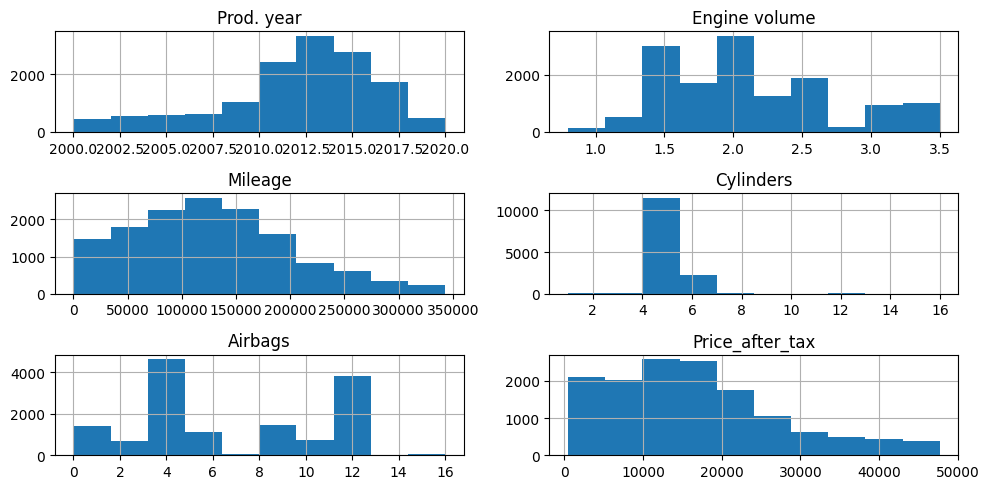

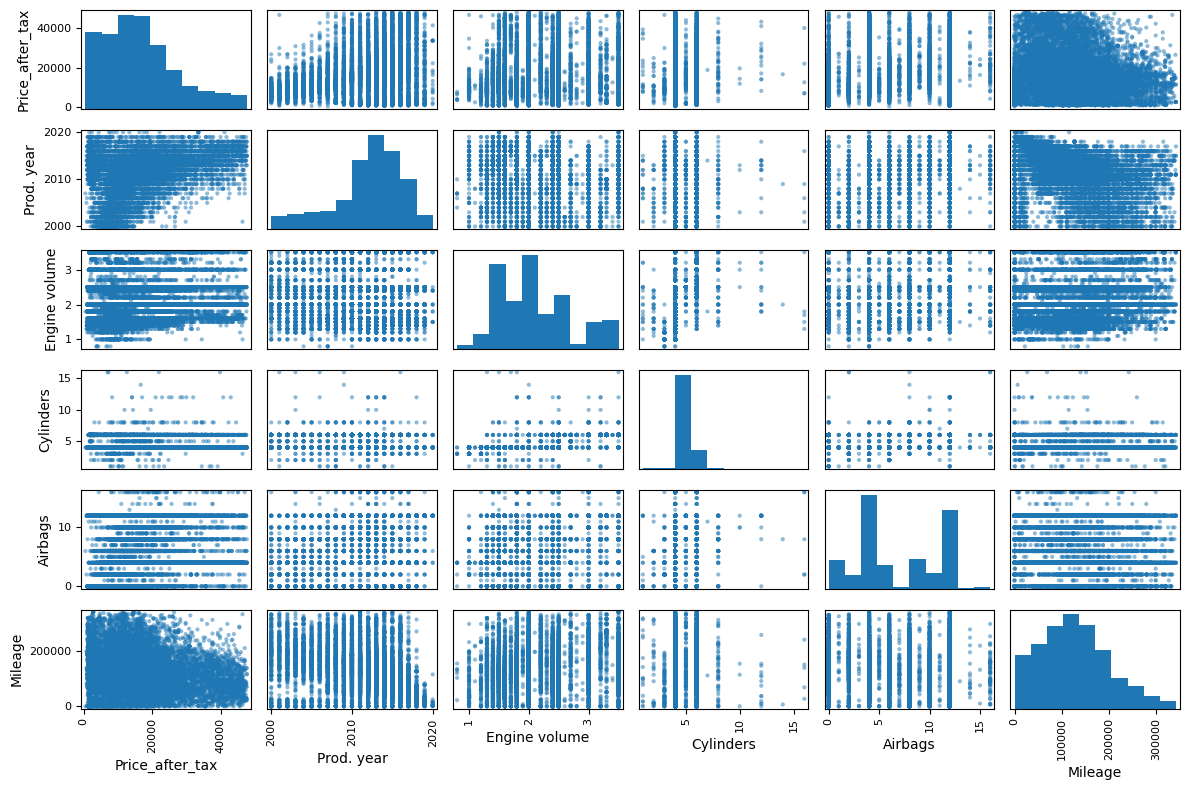

In [25]:
data_no_outliers.hist(figsize=(10,5)) #bins: no. of intervals
plt.tight_layout()

from pandas.plotting import scatter_matrix
def scatter(data_no_outliers):
	attributes = ['Price_after_tax', 'Prod. year', 'Engine volume', 'Cylinders', 'Airbags', 'Mileage'	]
	scatter_matrix(data_no_outliers[attributes], figsize=(12, 8))
	plt.tight_layout()
	plt.show()
scatter(data_no_outliers)

                 Prod. year  Engine volume   Mileage  Cylinders   Airbags  \
Prod. year         1.000000      -0.083239 -0.331611  -0.176778  0.180730   
Engine volume     -0.083239       1.000000  0.180720   0.654899  0.303147   
Mileage           -0.331611       0.180720  1.000000   0.149436 -0.024339   
Cylinders         -0.176778       0.654899  0.149436   1.000000  0.218923   
Airbags            0.180730       0.303147 -0.024339   0.218923  1.000000   
Price_after_tax    0.327300       0.038020 -0.191971  -0.033957 -0.088119   

                 Price_after_tax  
Prod. year              0.327300  
Engine volume           0.038020  
Mileage                -0.191971  
Cylinders              -0.033957  
Airbags                -0.088119  
Price_after_tax         1.000000  

 Price_after_tax    1.000000
Prod. year         0.327300
Engine volume      0.038020
Cylinders         -0.033957
Airbags           -0.088119
Mileage           -0.191971
Name: Price_after_tax, dtype: float64


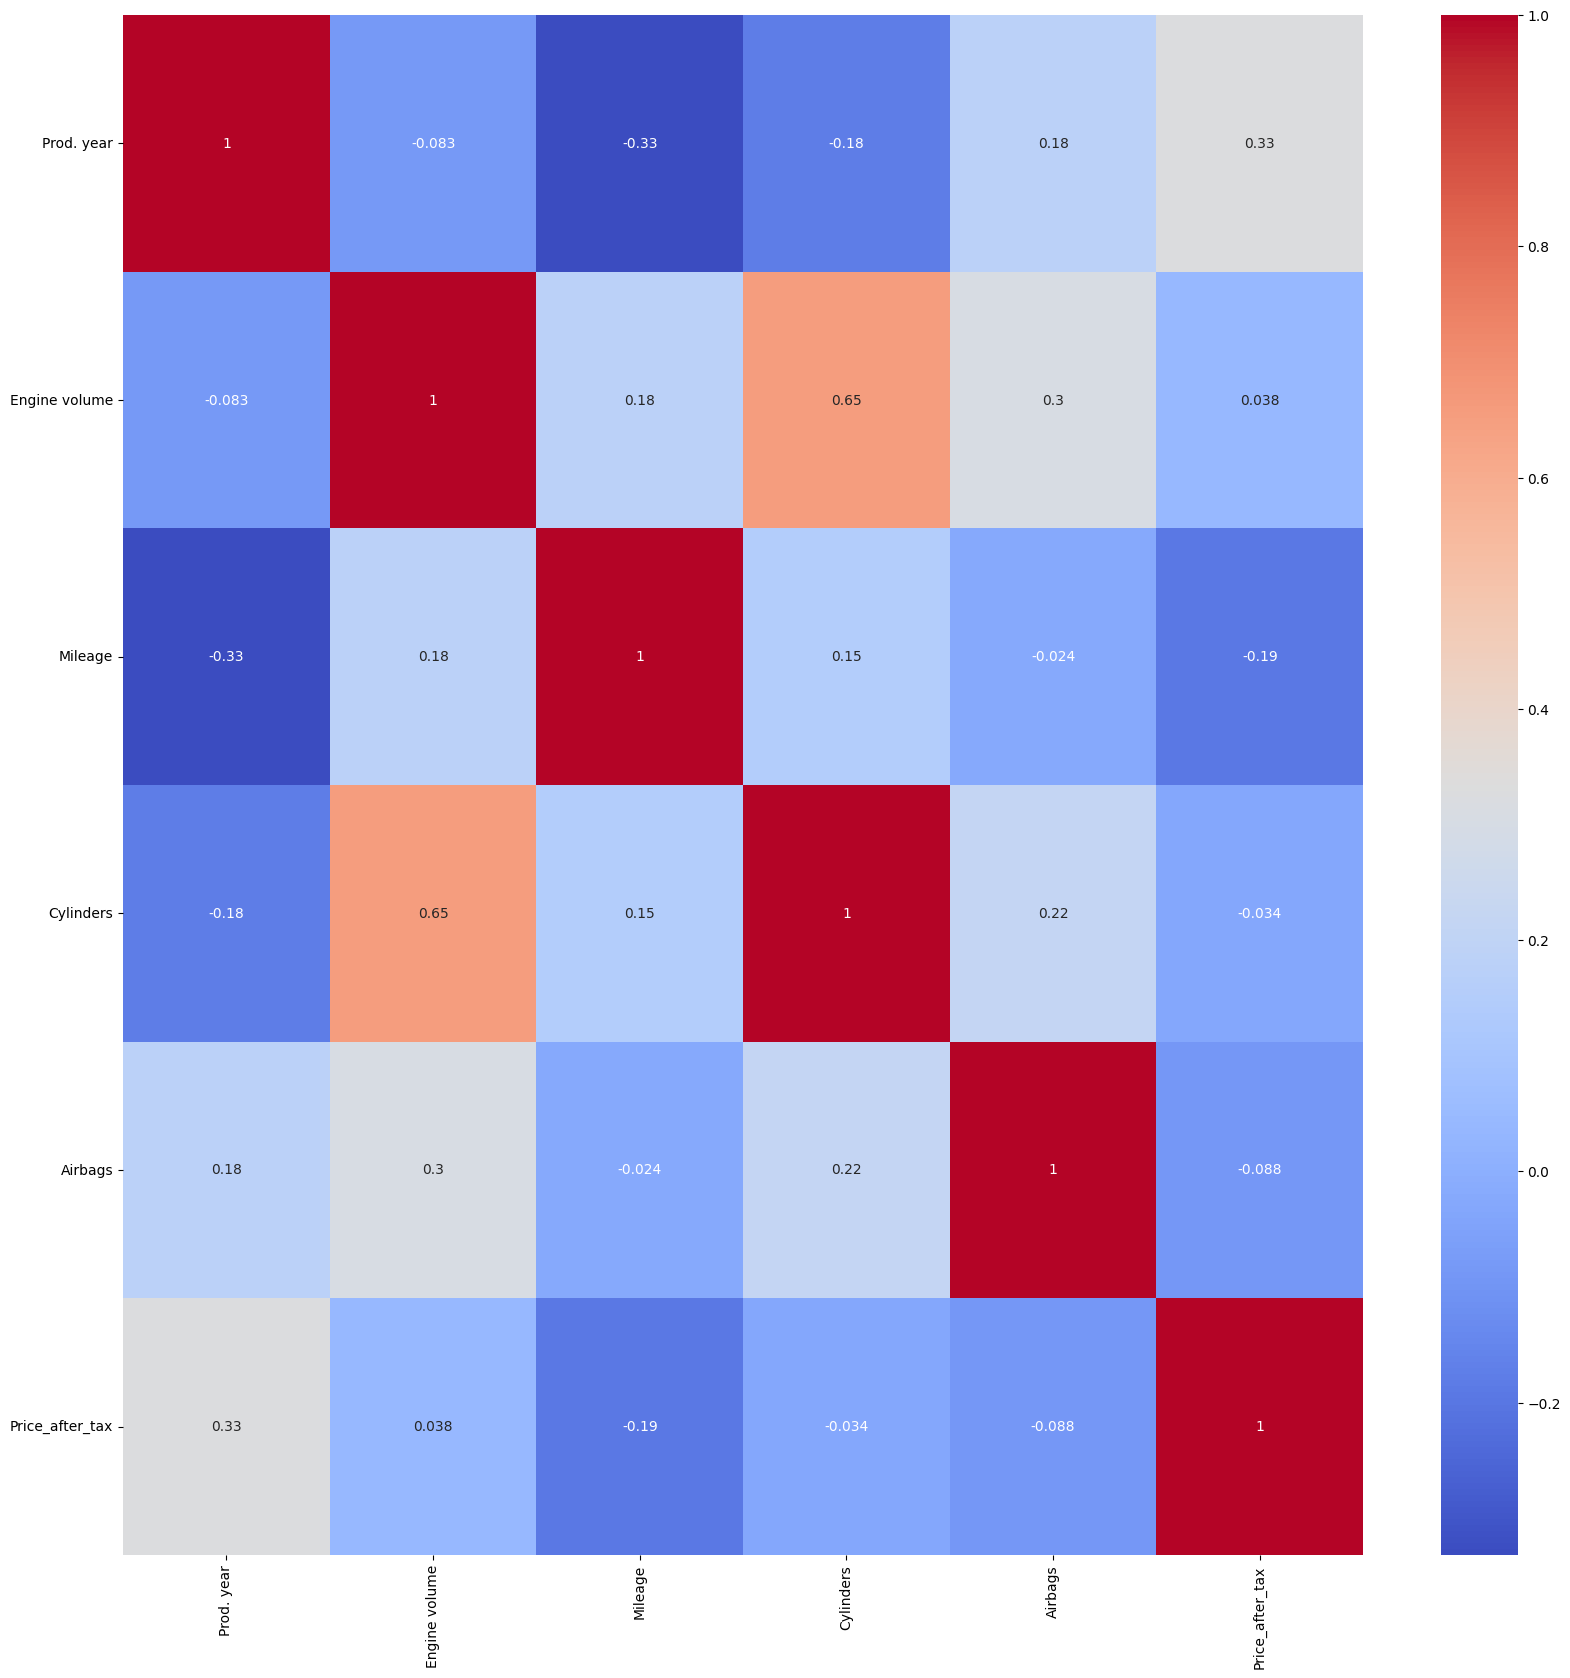

Cylinders
4.0     11396
6.0      2270
5.0       133
3.0        81
8.0        52
2.0        28
1.0        17
12.0       14
16.0        5
10.0        3
7.0         1
14.0        1
Name: count, dtype: int64


In [26]:
# 3.4 Correlation matrix
corr_matrix = data_no_outliers.corr(numeric_only=True)
print(corr_matrix) # print correlation matrix
print('\n',corr_matrix["Price_after_tax"].sort_values(ascending=False)) # print correlation b/w a feature and other features

columns = list(corr_matrix.columns)

columns.remove('Price_after_tax')
columns.append('Price_after_tax')
corr_matrix = corr_matrix.loc[columns, columns]

# Create a heatmap from the correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.xticks(rotation=90, fontsize=10)
# Rotate y-axis labels
plt.yticks(rotation=0, fontsize=10)
plt.show()
print(data_no_outliers['Cylinders'].value_counts()) 


In [27]:
data_no_outliers.head()

,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo,Price_after_tax
0,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,4-5,Left wheel,Silver,12,No,14727
1,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000,6.0,Tiptronic,4x4,4-5,Left wheel,Black,8,No,17639
2,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,4-5,Right-hand drive,Black,2,No,8467
3,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,4-5,Left wheel,White,0,No,4469
4,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,4-5,Left wheel,Silver,4,No,12172


In [28]:
# Remove Model
data_no_outliers = data_no_outliers.drop(columns=['Model'])

In [29]:
data_no_outliers.head()

,Manufacturer,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo,Price_after_tax
0,LEXUS,2010,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,4-5,Left wheel,Silver,12,No,14727
1,CHEVROLET,2011,Jeep,No,Petrol,3.0,192000,6.0,Tiptronic,4x4,4-5,Left wheel,Black,8,No,17639
2,HONDA,2006,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,4-5,Right-hand drive,Black,2,No,8467
3,FORD,2011,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,4-5,Left wheel,White,0,No,4469
4,HONDA,2014,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,4-5,Left wheel,Silver,4,No,12172


In [30]:
num_cols = data_no_outliers._get_numeric_data().columns.tolist()  
cat_cols = list(set(data_no_outliers.columns) - set(num_cols))  

print(f"Numerical features: {num_cols}")
print(f"Categorical features: {cat_cols}")

Numerical features: ['Prod. year', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags', 'Price_after_tax']
Categorical features: ['Category', 'Doors', 'Wheel', 'Drive wheels', 'Color', 'Gear box type', 'Turbo', 'Leather interior', 'Fuel type', 'Manufacturer']


In [31]:
# One-hot Encoder
df_cat_encoded = pd.get_dummies(data_no_outliers[cat_cols], drop_first=True)

df_final = pd.concat([data_no_outliers[num_cols], df_cat_encoded], axis=1)

print(f"Final DataFrame shape: {df_final.shape}")
df_final.head()

Final DataFrame shape: (14001, 102)


,Prod. year,Engine volume,Mileage,Cylinders,Airbags,Price_after_tax,Category_Coupe,Category_Goods wagon,Category_Hatchback,Category_Jeep,...,Manufacturer_SKODA,Manufacturer_SSANGYONG,Manufacturer_SUBARU,Manufacturer_SUZUKI,Manufacturer_TOYOTA,Manufacturer_UAZ,Manufacturer_VAZ,Manufacturer_VOLKSWAGEN,Manufacturer_VOLVO,Manufacturer_სხვა
0,2010,3.5,186005,6.0,12,14727,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,2011,3.0,192000,6.0,8,17639,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,2006,1.3,200000,4.0,2,8467,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,2011,2.5,168966,4.0,0,4469,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,2014,1.3,91901,4.0,4,12172,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [62]:
# Assuming `data_no_outliers` has your original data and `price_column` is the column name for prices

# Calculate the correlation matrix for the entire DataFrame
correlation_matrix = df_final.corr()

# Extract the correlation values for the 'price_column' with all other variables
price_correlation = correlation_matrix['Price_after_tax'].sort_values(ascending=False)

features_to_keep = price_correlation[(price_correlation > 0.09) | (price_correlation < -0.09)].index
# Select the features to keep in the dataset
X_filtered = df_final[features_to_keep]

print(f"Kept features: {list(features_to_keep)}")
filtered_correlation_matrix = X_filtered.corr()['Price_after_tax'].sort_values(ascending=False)
print(filtered_correlation_matrix)

# print("Most correlated features")
# price_correlation.head(10)
# Print the correlations
# print(f"Correlation of categorical data with prices:\n{price_correlation}")


Kept features: ['Price_after_tax', 'Prod. year', 'Fuel type_Diesel', 'Manufacturer_HYUNDAI', 'Category_Jeep', 'Manufacturer_SSANGYONG', 'Gear box type_Tiptronic', 'Turbo_Yes', 'Leather interior_Yes', 'Category_Minivan', 'Manufacturer_NISSAN', 'Category_Hatchback', 'Category_Sedan', 'Fuel type_Hybrid', 'Wheel_Right-hand drive', 'Mileage']
Price_after_tax            1.000000
Prod. year                 0.327300
Fuel type_Diesel           0.291643
Manufacturer_HYUNDAI       0.231902
Category_Jeep              0.231371
Manufacturer_SSANGYONG     0.218538
Gear box type_Tiptronic    0.154769
Turbo_Yes                  0.131045
Leather interior_Yes       0.100160
Category_Minivan           0.093130
Manufacturer_NISSAN       -0.096357
Category_Hatchback        -0.141294
Category_Sedan            -0.153965
Fuel type_Hybrid          -0.163673
Wheel_Right-hand drive    -0.182791
Mileage                   -0.191971
Name: Price_after_tax, dtype: float64


In [63]:
# print("Least correlated features")
# price_correlation.tail(10)

In [64]:
price_correlation = features_to_keep['Price_after_tax'].sort_values(ascending=False)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
# Separate features (X) and target variable (y)
X = df_final.drop(columns=['Price_after_tax']) 
y = df_final['Price_after_tax']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply StandardScaler to the features
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(11200, 101)
(2801, 101)
(11200,)
(2801,)


In [ ]:
# Linear Regression 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test_scaled)

# valuate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R^2): {r2}")

Mean Squared Error (MSE): 68398967.00336927
R-squared (R^2): 0.4274474162069517


In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.01)  # Adjust alpha to control regularization strength
lasso.fit(X_train, y_train)
selected_features = X.columns[(lasso.coef_ != 0).ravel()]
print(f'Selected features: {selected_features}')

Selected features: Index(['Prod. year', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags',
       'Category_Coupe', 'Category_Goods wagon', 'Category_Hatchback',
       'Category_Jeep', 'Category_Limousine', 'Category_Microbus',
       'Category_Minivan', 'Category_Pickup', 'Category_Sedan',
       'Category_Universal', 'Doors_4-5', 'Doors_>5', 'Wheel_Right-hand drive',
       'Drive wheels_Front', 'Drive wheels_Rear', 'Color_Black', 'Color_Blue',
       'Color_Brown', 'Color_Carnelian red', 'Color_Golden', 'Color_Green',
       'Color_Grey', 'Color_Orange', 'Color_Pink', 'Color_Purple', 'Color_Red',
       'Color_Silver', 'Color_Sky blue', 'Color_White', 'Color_Yellow',
       'Gear box type_Manual', 'Gear box type_Tiptronic',
       'Gear box type_Variator', 'Turbo_Yes', 'Leather interior_Yes',
       'Fuel type_Diesel', 'Fuel type_Hybrid', 'Fuel type_Hydrogen',
       'Fuel type_LPG', 'Fuel type_Petrol', 'Fuel type_Plug-in Hybrid',
       'Manufacturer_ALFA ROMEO', 'Manufacturer_AU

c:\Users\lnkhu\OneDrive\Desktop\rmit\Modelling\.conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.900e+11, tolerance: 1.319e+08
  model = cd_fast.enet_coordinate_descent(


#### r-squre = 0.427 shows that model performs pretty bad

In [ ]:
# 4.4 Define pipelines for processing data. 
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
    def fit(self, dataframe, labels=None):
        return self
    def transform(self, dataframe):
        return dataframe[self.feature_names].values         

# categorical pipelines
cat_pipeline = Pipeline([
    ('selector', ColumnSelector(cat_cols)),
    ('imputer', SimpleImputer(missing_values="-1", strategy="constant", fill_value = "NO INFO", copy=True)), # complete missing values. copy=False: imputation will be done in-place 
    ('cat_encoder', OneHotEncoder()) # convert categorical data into one-hot vectors
    ])    

# # 4.4.3 Define MyFeatureAdder: a transformer for adding features "TOTAL NUMBER OF BEDROOMS",...  
# class MyFeatureAdder(BaseEstimator, TransformerMixin):
#     def __init__(self, add_TOTAL_NO_OF_ROOMS = True): # MUST NO *args or **kargs
#         self.add_TOTAL_NO_OF_ROOMS = add_TOTAL_NO_OF_ROOMS
#     def fit(self, feature_values, labels = None):
#         return self  # nothing to do here
#     def transform(self, feature_values, labels = None):
#         if self.add_TOTAL_NO_OF_ROOMS:        
#             NO_OF_ROOMS_id, NO_OF_TOILETS_id = 1, 2 # column indices in num_feat_names. can't use column names b/c the transformer SimpleImputer removed them
#             # NOTE: a transformer in a pipeline ALWAYS return dataframe.values (ie., NO header and row index)
            
#             TOTAL_NO_OF_ROOMS = feature_values[:, NO_OF_ROOMS_id] + feature_values[:, NO_OF_TOILETS_id]
#             feature_values = np.c_[feature_values, TOTAL_NO_OF_ROOMS] #concatenate np arrays
#         return feature_values


# 4.4.4 Pipeline for numerical features
num_cols.remove("Price")
num_pipeline = Pipeline([
    ('selector', ColumnSelector(num_cols)),
    ('imputer', SimpleImputer(missing_values= -1, strategy="median", copy=True)), # copy=False: imputation will be done in-place 
    # ('attribs_adder', MyFeatureAdder(add_TOTAL_NO_OF_ROOMS = True)),
    ('std_scaler', StandardScaler(with_mean=True, with_std=True, copy=True)) # Scale features to zero mean and unit variance
    ])  

# 4.4.5 Combine features transformed by two above pipelines
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline) ])  


# # 4.5 Run the pipeline to process training data           
processed_train_set_val = full_pipeline.fit_transform(train_set)
print('\n____________ Processed feature values ____________')
print(processed_train_set_val[[0, 1, 2],:].toarray())
print(processed_train_set_val.shape)
# print('We have %d numeric feature + 1 added features + 35 cols of onehotvector for categorical features.' %(len(num_cols)))
# joblib.dump(full_pipeline, r'models/full_pipeline.pkl')

ValueError: list.remove(x): x not in list

In [ ]:
# # (optional) Add header to create dataframe. Just to see. We don't need header to run algorithms 
# onehot_cols = []
# for val_list in full_pipeline.transformer_list[1][1].named_steps['cat_encoder'].categories_: 
# 	onehot_cols = onehot_cols + val_list.tolist()
# columns_header = train_set.columns.tolist() + ["TOTAL NUMBER OF BEDROOMS"] + onehot_cols
# for name in cat_feat_names:
# 	columns_header.remove(name)
# processed_train_set = pd.DataFrame(processed_train_set_val.toarray(), columns = columns_header)
# print('\n____________ Processed dataframe ____________')
# print(processed_train_set.info())
# print(processed_train_set.head())
